# Temporal Difference Methods

Combining DP and MC:

- Similarly to MC: model not needed, learning from *experience*
- Updating the state before reaching the end of the epoch (*bootstrapping*)

Variants of TD will be discussed not just during this lecture.

## TD Prediction

Given a policy $\pi$, we want to quantify $v_\pi(s)$ for all states.

Simple every-visit MC calculates:

$$
V(S_t)\gets V(S_t)+alpha[G_t-V(S_t)]
$$
Let's call this *constant-$\alpha$ MC* - normally $\alpha=\frac{1}{N_{S_t}}$ where $N_{S_t}$ is the number of updates of $S_t$.

Monte Carlo has to know $G_t$ that is known in the end of the episode.

TD approach leverages bootstrapping instead:

$V(S_t)\gets V(S_t) + \alpha[R_{t+1}+\gamma V(S_{t+1})-V(S_t)]$

In [20]:
import gym
import numpy as np

env = gym.make('FrozenLake8x8-v0')
V = np.zeros(64)

alpha = 0.1
gamma = 0.9

for i_episode in range(20000):
    observation = env.reset()
    done = False
    while not done:
        old_observation = observation
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        V[old_observation]+=alpha*(reward+gamma*V[observation]-V[old_observation])

In [21]:
lake = V.reshape(8,8)

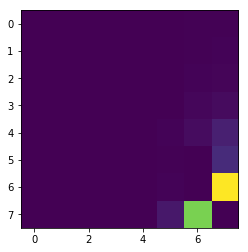

In [22]:
% matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(lake)

TD prediction can be easily integrated with Policy Improvement.

## Advantages of TD Prediction Methods

- Model not needed
- Fully online (also continuous, not only episodic tasks)
- Convergence? Yes.

Better than MC - hard to say in general; in practice TD is more succesful.

## Optimality of TD(0) 

Let's have finite amount of experience, e.g. 10 episodes.

Basic incremental approach: to keep updating based on the experience until convergence achieved.

We can apply:

- constant-$\alpha$ MC
- TD(0)

Who will be better?

Constant-$\alpha$ MC: *optimal* in terms of minimization of mean-squared-error from the *actual* returns $G$ in the training set.

TD faster. Why?

Better estimates used: not just *actual*, but *certainty-equivalence estimate* -  the models are coherent.

## Sarsa: On-policy TD Control


We will try to use Generalized Policy Improvement.

Similarly to Monte Carlo Methods, we distinguish:
* on-policy
* off-policy

We want to estimate $q_\pi(s,a)$. TD rule for this is:

$$
Q(S_t,A_t)\gets Q(S_t,A_t) + \alpha[R_{t+1}+\gamma Q(S_{t+1},A_{t+1})-Q(S_t,A_t)]
$$

Thus, we consider for one update the tuple $(S_t,A_t,R_{t+1},S_{t+1},A_{t+1})$ which gave the name to this approach: *Sarsa*.

In [68]:
Q = np.zeros((64,4))+0.5

alpha = 0.1
gamma = 0.9
epsilon = 0.1

for i_episode in range(20000):
    observation = env.reset()
    action = None
    done = False
    while not done:
        old_observation = observation
        old_action = action
        if np.random.random()<epsilon:
            action = env.action_space.sample()
        else:
            action = Q[observation,:].argmax()
        observation, reward, done, info = env.step(action)
        
        if action is not None:
            Q[old_observation,old_action]+=alpha*(reward+gamma*Q[observation,action]-Q[old_observation,old_action])

In [69]:
Q.mean()

0.31138428377290606

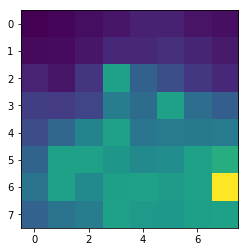

In [70]:
plt.imshow(Q[:,0].reshape(8,8))

In [74]:
import pandas as pd
pd.DataFrame(Q[:,0].reshape(8,8))

,0,1,2,3,4,5,6,7
0,0.049334,0.058759,0.078009,0.098144,0.120582,0.122512,0.091177,0.082144
1,0.069193,0.071422,0.096998,0.138479,0.136667,0.158092,0.130157,0.106284
2,0.128497,0.093309,0.167849,0.500000,0.292791,0.238934,0.176903,0.138140
3,0.195309,0.189831,0.213566,0.379304,0.328622,0.500000,0.332639,0.283978
4,0.235763,0.309015,0.404089,0.500000,0.358112,0.376940,0.369413,0.374389
5,0.303443,0.500000,0.500000,0.465405,0.424035,0.436316,0.500000,0.540942
6,0.351136,0.500000,0.425915,0.494061,0.500000,0.481284,0.500000,0.837240
7,0.296909,0.351054,0.384160,0.500000,0.472874,0.470277,0.495000,0.500000


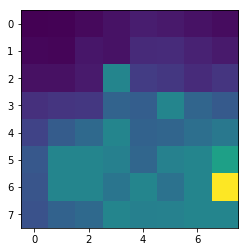

In [71]:
plt.imshow(Q[:,1].reshape(8,8))

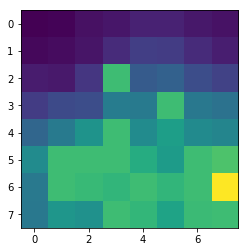

In [72]:
plt.imshow(Q[:,2].reshape(8,8))

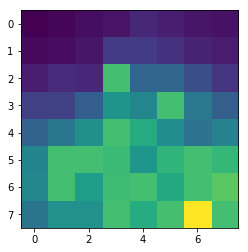

In [73]:
plt.imshow(Q[:,3].reshape(8,8))

Sarsa *converges* with probability 1 to an optimal policy as long as 

- all state-action pairs are visited an infinite number of times 
- and the policy in limit to the greedy policy (can be assured e.g. by $\epsilon=1/t$)

## Q-learning: Off-policy TD Control

As we know, off-policy means that we distinguish target and behavior policy.

The update is the following:

$$
Q(S_t,A_t)\gets Q(S_t,A_t)  + \alpha [R_{t+1}+\gamma \max_a Q(S_{t+1},a)-Q(S_t,A_t)]
$$

where the behavior is driven by a policy that can be derived from $Q$, e.g. $\epsilon$-greedy.

In [1]:
FROZEN LAKE?

Object `LAKE` not found.


In [ ]:
FROZEN LAKE

## Expected Sarsa

$$
Q(S_t,A_t)\gets Q(S_t,A_t)  + \alpha [R_{t+1}+\gamma \mathbb{E}_{\pi} (Q(S_{t+1},A_{t+1})|S_t)-Q(S_t,A_t)]
$$

$$
\gets Q(S_t,A_t) + \alpha [R_{t+1} + \gamma\sum_a \pi(a|S_{t+1})Q(S_{t+1,a})-Q(S_t,A_t)]
$$

It eliminates the variance due to random selection of $A_{t+1}$ in Sarsa.

Expected Sarsa can be both on-policy and off-policy.

What if target $\pi$ cannot be randomized, but is fully greedy.

## Maximization Bias and Double Learning

If $q(s,a)$ are all zeros, but the reward is random then, because of randomness: we will get one value as positive and it will be considered as maximum.

Maximization bias:

* If we use maximum of estimates as maximum of true values.

Trick: double learning - we distinuish $Q_1$ and $Q_2$ and we alter them randomly:

$$
Q_1(S_t,A_t)\gets Q(S_t,A_t)  + \alpha [R_{t+1}+\gamma Q_2(\arg\max_a Q_1(S_{t+1},a))-Q(S_t,A_t)]
$$

## Games, Afterstates, and Other Special Cases

After state = situation in environment immediately after an action is taken.

In games, we know how the board will look like after our action.

There are many action-state pairs that lead to the same afterstate. From value perspective, they are the same!

Similar setup - in other deterministic and structured problems:

- Queue in IT infrastructure
- Deletion of a file

## Summary

Benefits:

* Online
* Model free

We learned:

* Sarsa
* Q-learning
* Expected Sarsa

Our TD is:

* One-step = we can enhance to multi-step
* Tabular = we can use approximations for $Q$
* Model-free = we can do TD and benefit from models

Note: TD without actions can be helpful in some dynamic systems.

## Homework

Obligatory:

* Implement Q learning and Expected Sarsa for Frozen Lake.

Optional:

* Test Sarsa, Q learning, and Expected Sarsa on another environment.